In [5]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import os 
import networkx as nx
import igraph as ig
from ts2vg import NaturalVG
from scipy.spatial.distance import euclidean
from networkx import to_numpy_array

In [6]:
# # builds natural visibility graph
# vg = NaturalVG()
# vg.build(TS[:1000])

# import matplotlib.pyplot as plt
# ig.plot(vg.as_igraph())
# # plt.plot(TS[:1001])


In [7]:
# convert time series into natural visibility graphes
# https://github.com/CarlosBergillos/ts2vg

def construct_visibilty_graph(ts):
    # builds natural visibility graph
    vg = NaturalVG()
    vg.build(ts)
    # converts to networkx graph format
    g = vg.as_networkx()
    return g

def get_degree_sequence(vg):
    # get [(node, degrees),...] from a vg
    # convert to dict
    # get values (the degrees)
    ds = list(dict(nx.degree(vg)).values())
    return ds


In [8]:
# data input
singlechannel_timeseries = []
datadir = "../Singlechannel\PreviousData_v2\\"
for each in os.listdir(datadir):
    singlechannel_timeseries.append(list(scipy.io.loadmat(datadir+each)["X"][0]))

# plt.plot(TS)

TIMESTEP = 150
OVERLAP = 135
TS = singlechannel_timeseries[0]
TRUNCATED = len(TS) % TIMESTEP
SEGMENTS = [TS[i:i+TIMESTEP] for i in range(0, len(TS)-TIMESTEP+1, TIMESTEP-OVERLAP)] #(from 0 to last possible timestep, in steps of len of timestep (remove overlap))
print("Generated " + str(len(SEGMENTS)) + " segments of length " + str(len(SEGMENTS[0])) + " with overlap of " + str(OVERLAP) + " in a timeseries of length " + str(len(singlechannel_timeseries[0])))

Generated 1219 segments of length 150 with overlap of 135 in a timeseries of length 18434


In [9]:

normalized_distance_matrices = []

for ts in singlechannel_timeseries:
    # segment y_filtered into consecutive non-overlapping intervals
    segments = [ts[i:i+TIMESTEP] for i in range(0, len(ts)-TIMESTEP+1, TIMESTEP-OVERLAP)]
    print(np.array(segments).shape)

    # construct a visibility graph for each segment
    graphs = [construct_visibilty_graph(segment) for segment in segments]
    print(np.array(graphs).shape)

    # compute feature vectors for each graph using degree centrality
    feature_vectors = [np.array(list(nx.degree_centrality(graph).values())) for graph in graphs]
    print(np.array(feature_vectors).shape)

    # define distance matrix D for each segment using Euclidean distance
    distance_matrices = []
    for i in range(len(feature_vectors)):
        D = np.zeros((len(feature_vectors), len(feature_vectors)))
        for j in range(len(feature_vectors)):
            D[i][j] = np.linalg.norm(feature_vectors[i]-feature_vectors[j])
        distance_matrices.append(D)

    # compute global distance matrix by averaging distances across all segments
    global_distance_matrix = np.mean(distance_matrices, axis=0)
    print(np.array(global_distance_matrix).shape)

    # normalize global distance matrix between 0 and 1
    normalized_distance_matrix = 1 - (global_distance_matrix - np.min(global_distance_matrix)) / (np.max(global_distance_matrix) - np.min(global_distance_matrix))
    print(np.array(normalized_distance_matrix).shape)

    normalized_distance_matrices.append(normalized_distance_matrix)

# find the dimensions of the largest matrix
max_rows = max(normalized_distance_matrices, key=lambda x: x.shape[0]).shape[0]
max_cols = max(normalized_distance_matrices, key=lambda x: x.shape[1]).shape[1]

# iterate over each matrix in the list, padding with zeros if necessary
for i in range(len(normalized_distance_matrices)):
    rows = normalized_distance_matrices[i].shape[0]
    cols = normalized_distance_matrices[i].shape[1]
    if rows < max_rows:
        normalized_distance_matrices[i] = np.pad(normalized_distance_matrices[i], ((0,max_rows-rows),(0,0)), mode='constant')
    if cols < max_cols:
        normalized_distance_matrices[i] = np.pad(normalized_distance_matrices[i], ((0,0),(0,max_cols-cols)), mode='constant')

average_normalized_distance_matrix = np.mean(normalized_distance_matrices, axis=0)

# construct weighted graph C using normalized distance matrix as adjacency matrix
# threshold = 0.0  # set a threshold to remove weak edges
# C = nx.from_numpy_array(normalized_distance_matrix * (normalized_distance_matrix >= threshold))

C = nx.from_numpy_array(average_normalized_distance_matrix)

# Set edge weights to similarity values
for u, v, d in C.edges(data=True):
    d['weight'] = average_normalized_distance_matrix[u][v]
    
# Remove self-loops
C.remove_edges_from(nx.selfloop_edges(C))

weightedGraph = C

# Draw the weighted graph
nx.draw(C)


(1219, 150)
(1219, 150)
(1219, 150)


KeyboardInterrupt: 

Without any of the multichannel processing, need to generate single normalized 

(1219, 150)
(1219, 150)
(1219, 150)
(1219, 1219)
(1219, 1219)


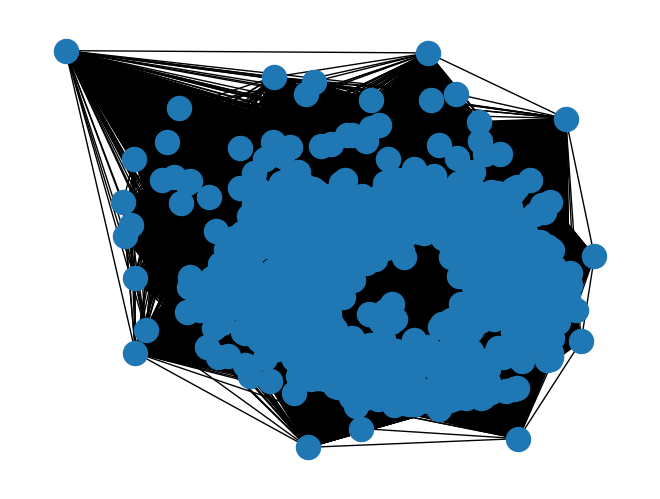

In [ ]:
# segment y_filtered into consecutive non-overlapping intervals
segments = [TS[i:i+TIMESTEP] for i in range(0, len(TS)-TIMESTEP+1, TIMESTEP-OVERLAP)]
print(np.array(segments).shape)

# construct a visibility graph for each segment
graphs = [construct_visibilty_graph(segment) for segment in segments]
print(np.array(graphs).shape)

# compute feature vectors for each graph using degree centrality
feature_vectors = [np.array(list(nx.degree_centrality(graph).values())) for graph in graphs]
print(np.array(feature_vectors).shape)

# define distance matrix D for each segment using Euclidean distance
distance_matrices = []
for i in range(len(feature_vectors)):
    D = np.zeros((len(feature_vectors), len(feature_vectors)))
    for j in range(len(feature_vectors)):
        D[i][j] = np.linalg.norm(feature_vectors[i]-feature_vectors[j])
    distance_matrices.append(D)

# compute global distance matrix by averaging distances across all segments
global_distance_matrix = np.mean(distance_matrices, axis=0)
print(np.array(global_distance_matrix).shape)

# normalize global distance matrix between 0 and 1
normalized_distance_matrix = 1 - (global_distance_matrix - np.min(global_distance_matrix)) / (np.max(global_distance_matrix) - np.min(global_distance_matrix))
print(np.array(normalized_distance_matrix).shape)

# construct weighted graph C using normalized distance matrix as adjacency matrix
# threshold = 0.0  # set a threshold to remove weak edges
# C = nx.from_numpy_array(normalized_distance_matrix * (normalized_distance_matrix >= threshold))

C = nx.from_numpy_array(normalized_distance_matrix)

# Set edge weights to similarity values
for u, v, d in C.edges(data=True):
    d['weight'] = normalized_distance_matrix[u][v]
    
# Remove self-loops
C.remove_edges_from(nx.selfloop_edges(C))

weightedGraph = C

# Draw the weighted graph
nx.draw(C)


{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 3, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 2, 24: 1, 25: 3, 26: 3, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 3, 33: 3, 34: 3, 35: 3, 36: 3, 37: 3, 38: 3, 39: 3, 40: 3, 41: 3, 42: 3, 43: 3, 44: 3, 45: 3, 46: 3, 47: 3, 48: 3, 49: 3, 50: 3, 51: 3, 52: 3, 53: 3, 54: 3, 55: 3, 56: 3, 57: 3, 58: 3, 59: 3, 60: 3, 61: 3, 62: 3, 63: 3, 64: 3, 65: 3, 66: 3, 67: 1, 68: 1, 69: 1, 70: 1, 71: 2, 72: 3, 73: 3, 74: 3, 75: 3, 76: 3, 77: 3, 78: 3, 79: 3, 80: 3, 81: 3, 82: 3, 83: 3, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 2, 98: 3, 99: 3, 100: 3, 101: 3, 102: 3, 103: 3, 104: 3, 105: 3, 106: 3, 107: 3, 108: 3, 109: 3, 110: 1, 111: 1, 112: 1, 113: 1, 114: 1, 115: 1, 116: 1, 117: 1, 118: 1, 119: 1, 120: 1, 121: 1, 122: 1, 123: 1, 124: 1, 125: 1, 126: 1, 127: 1, 128: 1, 129: 1, 130: 1, 131: 1, 132: 1, 133: 1, 134: 1, 135: 1, 136: 1, 137: 1, 138: 

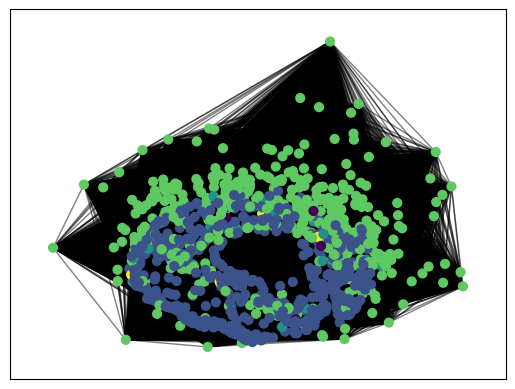

In [ ]:
# community detection (clustering) of weighted graphes
# https://github.com/taynaud/python-louvain

# To achieve a modular visualization of the clusters detected by the discussed method and their
# mutual connections, we used a force-directed algorithm, namely the Frushterman–Reingold layout,
# as a graphical representation.
# Finally, for specific unsupervised FSS purposes, we considered a representative parameter for
# each cluster. Such parameters were identified based on their importance within the communities,
# by considering the signals with highest total degree centrality in their respective groups.

from community import community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

partition = community_louvain.best_partition(weightedGraph, resolution=(1.02))

print(partition)

# draw the graph
pos = nx.spring_layout(weightedGraph)
# color the nodes according to their partition
cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(weightedGraph, pos, partition.keys(), node_size=40,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(weightedGraph, pos, alpha=0.5)
plt.show()

# try averaging matrix across subjects, try concatenate signals end to end 


{0, 1, 2, 3, 4}


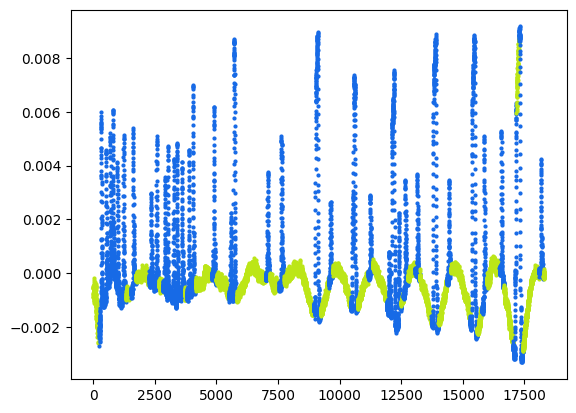

In [ ]:
import matplotlib.pyplot as plt
print(set(list(partition.values())))


#majority voting method for overlapping clusters
# Create the dictionary

TSFAKE = [*range(len(TS))]
SEGMENTSFAKE = [TSFAKE[i:i+TIMESTEP] for i in range(0, len(TS)-TIMESTEP+1, TIMESTEP-OVERLAP)] #(from 0 to last possible timestep, in steps of len of timestep (remove overlap))
occuranceTable = {i: [segmentNum for segmentNum in range(len(SEGMENTSFAKE)) if i in SEGMENTSFAKE[segmentNum]] for i in range(len(TS) - TRUNCATED) if any(i in seg for seg in SEGMENTSFAKE)}
# print(occuranceTable)
# occuranceTable = {}
# for i in range(len(TS) - TRUNCATED) :
#     indices = []
#     for j, seg in enumerate(SEGMENTSFAKE):
#         if i in seg:
#             indices.append(j)
#     if indices:
#         occuranceTable[i] = indices

majority_partition = {}
# iterate over time steps
for i in range(len(TS) - TRUNCATED):
    partitions = {} # dictionary to store frequency of partitions in current time step
    
    # iterate over segments in current time step
    for segmentNum in occuranceTable[i]:
        p = partition[segmentNum] # get partition of current segment
        if p not in partitions:
            partitions[p] = 1
        else:
            partitions[p] += 1
        
    # assign majority partition for current timestep
    majority = max(partitions, key=partitions.get)
    majority_partition[i] = majority

import colorsys
n_colors = len(set(list(partition.values())))  # number of colors to generate
colors = {}
for i in range(n_colors): # generates highly contrasting colors by incrementing hue
    hue = i / float(n_colors)
    saturation = 0.9
    value = 0.9
    (r, g, b) = colorsys.hsv_to_rgb(hue, saturation, value)
    colors[i] = (r, g, b)

for i in range(len(TS) - TRUNCATED):
    plt.plot(i, TS[i], marker='o', markersize=2, color=colors[majority_partition[i]])

    
plt.show()

# each timestep section assigned color of respective partition
# for i in range(len(SEGMENTS)):
#     plt.plot(range(TIMESTEP*i, TIMESTEP*(i+1)), SEGMENTS[i], marker='o', markersize=2, color=colors[partition[i]])

# plt.show()


In [ ]:
# pruning of graphes
# perform edge pruning by filtering the pairwise similarities lower than the second quantile of their probability distribution